In [2]:
import os
import numpy as np
from keras import layers
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.models import Model
from keras.initializers import glorot_uniform

os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train_onehot = to_categorical(y_train, num_classes=None, dtype='float32')
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

11501568/11490434 [==============================] - 0s 0us/step
Train Set Size = 60000 images
Test Set Size = 10000 images


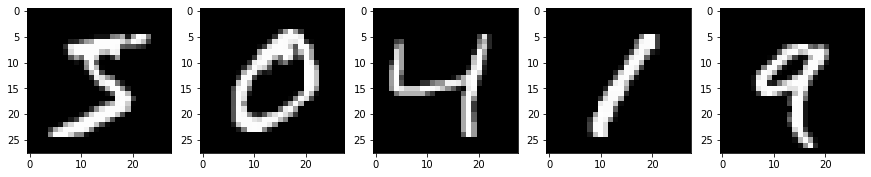

Labels : [5 0 4 1 9]


In [4]:
fig1 = plt.figure(figsize = (15,15))
for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
plt.show()
print("Labels : {}".format(y_train[0:5]))

In [5]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def resNet():
    
    # Define the input as a tensor with shape input_shape
    X_input = Input((28,28,1))
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # AVGPOOL
    # X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(y_train_onehot.shape[1], activation='softmax', name='fc' + str(y_train_onehot.shape[1]))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    #Compile the model
    model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
    return model



In [6]:
model = resNet()

In [7]:
nb_epoch = 25
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_resNet():
    
    history = LossHistory()
    # x_train & x_test reshaped because of single channel !
    model.fit(x_train.reshape((-1,28,28,1)), y_train_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test.reshape((-1,28,28,1)), verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err


In [8]:
predictions, history = run_resNet()

Epoch 1/25
352/352 [==============================] - 68s 144ms/step - loss: 0.3767 - accuracy: 0.8976 - val_loss: 0.2287 - val_accuracy: 0.9327
Epoch 2/25
352/352 [==============================] - 47s 133ms/step - loss: 0.0797 - accuracy: 0.9754 - val_loss: 0.1292 - val_accuracy: 0.9635
Epoch 3/25
352/352 [==============================] - 47s 133ms/step - loss: 0.0507 - accuracy: 0.9842 - val_loss: 0.1157 - val_accuracy: 0.9689
Epoch 4/25
352/352 [==============================] - 47s 133ms/step - loss: 0.0500 - accuracy: 0.9843 - val_loss: 0.0753 - val_accuracy: 0.9789
Epoch 5/25
352/352 [==============================] - 47s 133ms/step - loss: 0.1087 - accuracy: 0.9684 - val_loss: 0.0794 - val_accuracy: 0.9751
Epoch 6/25
352/352 [==============================] - 48s 137ms/step - loss: 0.0411 - accuracy: 0.9876 - val_loss: 0.0634 - val_accuracy: 0.9826
Epoch 7/25
352/352 [==============================] - 47s 133ms/step - loss: 0.0287 - accuracy: 0.9911 - val_loss: 0.0808 - val_ac

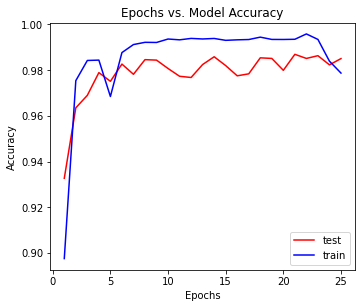

In [14]:
fig10 = plt.figure(figsize = (12,10))
ax1 = fig10.add_subplot(2,2,1)

ax1.plot(np.arange(1,nb_epoch+1), history.val_acc, color='red', label='test')
ax1.plot(np.arange(1,nb_epoch+1), history.acc, color='blue', label='train')

ax1.set(xlabel='Epochs', ylabel='Accuracy',
       title='Epochs vs. Model Accuracy')
plt.legend()
plt.show()


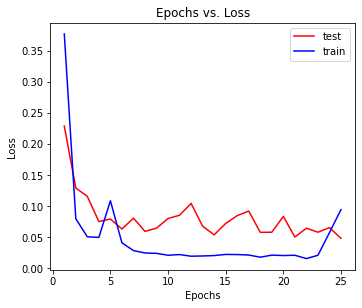

In [12]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
#ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), history.val_losses, color='r', label='test')
ax1.plot(np.arange(1,nb_epoch+1), history.losses, color='b', label='train')

ax1.set(xlabel='Epochs', ylabel='Loss',
       title='Epochs vs. Loss')
plt.legend()
plt.show()